In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3Plus, MAnet, FPN
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils import train as smp_train
from segmentation_models_pytorch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler

from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore
from torchmetrics import Accuracy, F1Score, Precision, Recall, ConfusionMatrix, AUROC

import os
import cv2
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import echoregions as er

import warnings
from dask.diagnostics import ProgressBar
import math
import xarray as xr

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SET UP INPUT/OUTPUT PATHS

In [3]:
import pandas as pd

img_dir = '/media/ubuntu/E/Test_ML/imgs'
mask_dir = '/media/ubuntu/E/Test_ML/masks'
binary_mask_dir = '/media/ubuntu/E/Test_ML/binary_masks'
output_predictions = '/media/ubuntu/E/Test_ML/predictions'
output_predictions_combined = '/media/ubuntu/E/Test_ML/combined_predictions'

ignore_vars = ['source_filenames', 'filenames', 'angle_offset_alongship', 'angle_offset_athwartship',
                'beamwidth_alongship', 'beamwidth_athwartship', 'water_level', 'angle_sensitivity_alongship',
               'angle_sensitivity_athwartship', 'equivalent_beam_angle', #frequency_nominal,
               'gain_correction', 'sa_correction', 'sound_absorption', 'sound_speed'
              ]

testing = True

# This part is needed only for testing, not for inference
if testing:
    evr_dir = '/media/ubuntu/E/EVR_region_files'
    region_classes=["Def herring", "Prob herring", "Poss herring", "Surface herring", "Mackerel", 
                                                   "Gadoids", "Norway pout", "unidentified fish"]
    region_classes_df = pd.DataFrame({'class': region_classes}, index=range(1, len(region_classes)+1))
    region_classes_df.to_csv(os.path.join(mask_dir, 'classes.csv'))
    region_classes_df['class_ind'] = region_classes_df.index.astype(int)

# CUT AND PAD ONE DATASET

In [4]:
warnings.filterwarnings("ignore", category=UserWarning, message="Returning No Mask. Empty 3D Mask cannot be converted to 2D Mask.")
warnings.filterwarnings("ignore", category=UserWarning, message="No gridpoint belongs to any region.")

chunk_sizes = {
    'channel': -1,           # Load all channels in one chunk
    'ping_time': 100,        # Chunk by 100
    'range_sample': 650      # Split into 2 chunks
}

def def load_zarr_lazy(zarr_path, chunk_sizes=chunk_sizes, ignore_vars = []):
    return xr.open_zarr(zarr_path, chunks=chunk_sizes, drop_variables = ignore_vars)    

def correct_echo_range(ds):
    # Replace channel and ping_time with their first elements
    first_channel = ds["channel"].values[0]
    first_ping_time = ds["ping_time"].values[0]
    
    # Slice the echo_range to get the desired range of values
    selected_echo_range = ds["echo_range"].sel(channel=first_channel, ping_time=first_ping_time)
    selected_echo_range = selected_echo_range.values.tolist()
    selected_echo_range = [value + 8.6 for value in selected_echo_range]

    min_val = np.nanmin(selected_echo_range)
    max_val = np.nanmax(selected_echo_range)
    
    # Assign the values to the depth coordinate, transducer offset 8.6m
    ds = ds.assign_coords(range_sample=selected_echo_range)

    # Remove nan values
    ds = ds.sel(range_sample=slice(min_val, max_val))
    
    return ds

# Normalization channel by channel, so that all NaN channels
# are treated correctly
def normalize_each_channel(data):
    # Iterate over each channel
    for channel in range(data.shape[2]):
        channel_data = data[:, :, channel]
        
        if np.isnan(channel_data).all():
            # If all values in the channel are NaN, replace them with 0
            data[:, :, channel] = 0
        else:
            # Replace NaNs with the minimum value - 10 for the channel
            min_val = np.nanmin(channel_data)
            channel_data = np.where(np.isnan(channel_data), min_val - 10, channel_data)
            
            # Calculate the minimum and maximum values for the channel
            min_val = np.nanmin(channel_data)
            max_val = np.nanmax(channel_data)
            
            # Calculate normalization parameters
            range_val = max_val - min_val
            if range_val == 0:
                range_val = 1  # Avoid division by zero
            
            # Normalize the channel data
            data[:, :, channel] = (channel_data - min_val) / range_val
    
    return data   

def load_combine_process_zarrs(zarr_paths, ignore_vars = []):
    datasets = [load_zarr_lazy(path, chunk_sizes = {}, ignore_vars = ignore_vars) for path in zarr_paths]
    combined_dataset = xr.concat(datasets, dim='ping_time')
    combined_dataset = combined_dataset.sortby('ping_time')
    # select first 3 channels
    combined_dataset = combined_dataset.isel(channel=slice(0, 3))
    # remove empty pings
    combined_dataset = combined_dataset.dropna(dim='ping_time', how='all', subset=['Sv'])
    # correct depth
    combined_dataset = correct_echo_range(combined_dataset)
    #combined_dataset = apply_remove_background_noise(combined_dataset)
    combined_dataset = combined_dataset.rename({'range_sample': 'depth'})
    return combined_dataset

def chunk_mask(combined_dataset, regions2d_list, date, chunk_ratio = 1, min_nonzero = 0):
    # Cut image and mask into chunks equal to the height * chunk_ratio
    ds_lengh = combined_dataset.sizes['ping_time']
    chunk_size = int(combined_dataset.sizes['depth']) 
    num_chunks = math.ceil(ds_lengh / chunk_size)
    for i in tqdm(range(0, num_chunks), total = num_chunks, leave = False):
        start = i*chunk_size
        end = min((i+1)*chunk_size, ds_lengh)
        chunk = combined_dataset.isel(ping_time=slice(start,end))["Sv"]
        #print(chunk['ping_time'].min().values, chunk['ping_time'].max().values)

        # if there are any annotations, create masks
        if len(regions2d_list) > 0:
            mask = None
            for regions2d in regions2d_list:
                region_mask_ds, region_points = regions2d.mask(
                            chunk.isel(channel=1).drop_vars("channel"),
                            region_class=region_classes,
                            collapse_to_2d = True
                        )
                if region_mask_ds:
                    loc_mask = region_mask_ds['mask_2d'].fillna(0).values.astype(int)
                    
                    # Replace region_id with class_id in the mask
                    region_class_mapping = regions2d.data.merge(region_classes_df, how='left', left_on = 'region_class', right_on = 'class')
                    region_class_mapping = region_class_mapping[region_class_mapping.region_id.isin(np.unique(loc_mask))][['region_id', 'class_ind']].astype(int).sort_values(by='region_id')
                    for _, row in region_class_mapping.iterrows():
                        loc_mask[loc_mask == row.region_id] = row.class_ind
                    
                    if mask is not None and mask.size > 0:
                        mask = mask + loc_mask
                    else:
                        mask = loc_mask

        fname = '%s_%d.npy' % (date, i)
        
        chunk_filepath = os.path.join(img_dir, fname)
        chunk = normalize_each_channel(chunk.values.T)
        if chunk.shape[1]<chunk_size:  # Handle the last segment which might need padding
                pad_width = chunk_size - chunk.shape[1]
                pad_tuple = ((0, 0), (0, pad_width), (0, 0))  # No padding for the height and channels, padding for width
                chunk = np.pad(chunk, pad_tuple, mode='constant', constant_values=0)

        np.save(chunk_filepath, chunk)
        chunk = None

        # if there are any annotations, create masks
        if len(regions2d_list) > 0:
            if mask is not None and mask.size > 0:
                binary_mask = (mask > 0).astype(int)
                if binary_mask.shape[1]<chunk_size:
                    pad_tuple = ((0, 0), (0, pad_width, 0))  # No padding for the height, padding for width
                    binary_mask = np.pad(binary_mask, pad_tuple, mode='constant', constant_values=0)
            else:
                binary_mask = np.zeros((chunk_size, chunk_size))
                
            binary_mask_filepath = os.path.join(binary_mask_dir, fname)
            np.save(binary_mask_filepath, binary_mask)
            binary_mask = None
    return chunk_size, num_chunks

def process_one_day(zarr_paths, evr_paths, date, chunk_ratio = 1, min_nonzero = 0, ignore_vars = []):
    combined_dataset = load_combine_process_zarrs(zarr_paths)

    # there can be several evr files or none
    if len(evr_paths) > 0:
        regions2d_list = [er.read_evr(evr_file) for evr_file in evr_paths]
    else: 
        regions2d_list = []

    depth, num_chunks = chunk_mask(combined_dataset, regions2d_list, date, chunk_ratio, min_nonzero, ignore_vars = ignore_vars)
    return depth, num_chunks

In [188]:
date = '0707'
zarr_dir = '/media/ubuntu/E/processed/070707'
zarr_paths = [os.path.join(zarr_dir, z, z + '_Sv.zarr') for z in os.listdir(zarr_dir)]

# If it's inference only, no testing, then no evr_file needs to be provided, just an empty list
if testing: 
    evr_file = '/media/ubuntu/E/EVR_region_files/07July.EVR'
    evr_files = [evr_file]
else: 
    evr_files = []
depth, num_chunks = process_one_day(zarr_paths, evr_files, date, ignore_vars = ignore_vars)

# It's important to sort the filenames according to how they were chunked
test_images = [os.path.join(img_dir, date+'_'+str(i)+'.npy') for i in range(0, num_chunks)]
# Masks are needed in case of testing only
if testing:
    test_masks = [os.path.join(binary_mask_dir, date+'_'+str(i)+'.npy') for i in range(0, num_chunks)]

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


  0%|          | 0/62 [00:00<?, ?it/s]

# LOAD TRAINED MODEL

In [191]:
class SegModel(pl.LightningModule):
    def __init__(self, model, threshold = 0.5):
        """
        Initialize the SegModel.

        Parameters:
        - model: PyTorch model, the segmentation model to be used.
        - criterion: loss function.
        - optimizer: optimizer function.
        - threshold: float, threshold for converting probabilities to binary predictions. Default is 0.5.
        """
        super().__init__()
        self.model = model
        self.threshold = threshold

        self.iou = MeanIoU(num_classes=2, per_class=True)  
        self.precision = Precision(task="multiclass", num_classes=2, average='none')
        self.recall = Recall(task="multiclass", num_classes=2, average='none')
        self.f1 = F1Score(task="multiclass", num_classes=2, average='none')
        self.dice = GeneralizedDiceScore(num_classes=2, include_background=True, per_class=True)
        self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=2)
        self.auroc = AUROC(task="binary")

        self.test_outputs = []
        
    def forward(self, x):
        return self.model(x)

    def test_step(self, batch, batch_idx):
        """
        Test step to compute various metrics.

        Parameters:
        - batch: the input batch containing images and masks.
        - batch_idx: int, the index of the current batch.

        Returns:
        - dict: contains various metrics for the current batch.
        """
        x, y = batch
        logits = self(x)
        preds = torch.sigmoid(logits) > self.threshold
        preds = preds.int()  # Convert boolean to integers
        y = y.int()  # Ensure targets are also integers

        self.precision.reset()
        self.recall.reset()
        self.f1.reset()
        self.iou.reset()
        
        # Update metrics
        iou_score = self.iou(preds, y)
        dice_score = self.dice(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        f1 = self.f1(preds, y)
        cm = self.confusion_matrix(preds, y).float()
        auroc = self.auroc(preds, y)

        outputs = {
            "iou": iou_score,
            "dice": dice_score,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm,
            "auroc": auroc
        }

        self.test_outputs.append(outputs)
        
        return outputs

    def on_test_epoch_end(self):
        """
        Aggregates metrics at the end of the test epoch and logs them.
        """
        iou_scores = torch.stack([x['iou'] for x in self.test_outputs])
        dice_scores = torch.stack([x['dice'] for x in self.test_outputs])
        precisions = torch.stack([x['precision'] for x in self.test_outputs])
        recalls = torch.stack([x['recall'] for x in self.test_outputs])
        f1_scores = torch.stack([x['f1'] for x in self.test_outputs])
        cm_scores = torch.stack([x['confusion_matrix'] for x in self.test_outputs])
        auroc_scores = torch.stack([x['auroc'] for x in self.test_outputs])
            
        # Sum confusion matrices
        sum_cm = cm_scores.sum(dim=0)
        sum_cm_np = sum_cm.cpu().numpy()  # Convert to numpy array
        cm_normalized = sum_cm_np.astype('float') / sum_cm_np.sum(axis=1)[:, np.newaxis]

        avg_auroc = auroc_scores.mean()

        avg_iou_background = iou_scores[:, 0].mean()
        avg_iou_class_of_interest = iou_scores[:, 1].mean()

        avg_dice_background = dice_scores[:, 0].mean()
        avg_dice_class_of_interest = dice_scores[:, 1].mean()
        
        avg_precision_background = precisions[:, 0].mean()
        avg_precision_class_of_interest = precisions[:, 1].mean()
        avg_recall_background = recalls[:, 0].mean()
        avg_recall_class_of_interest = recalls[:, 1].mean()
        avg_f1_background = f1_scores[:, 0].mean()
        avg_f1_class_of_interest = f1_scores[:, 1].mean()
    
        # Log aggregated metrics
        self.log('avg_auroc', avg_auroc)
        
        self.log('avg_iou_background', avg_iou_background)
        self.log('avg_iou_class_of_interest', avg_iou_class_of_interest)
        
        self.log('avg_dice_background', avg_dice_background)
        self.log('avg_dice_class_of_interest', avg_dice_class_of_interest)
        
        self.log('avg_precision_background', avg_precision_background)
        self.log('avg_precision_class_of_interest', avg_precision_class_of_interest)
        self.log('avg_recall_background', avg_recall_background)
        self.log('avg_recall_class_of_interest', avg_recall_class_of_interest)
        self.log('avg_f1_background', avg_f1_background)
        self.log('avg_f1_class_of_interest', avg_f1_class_of_interest)
    
        # Plot the normalized confusion matrix
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm_normalized, annot=True, fmt='.4f', cmap='Blues', xticklabels=['BG', 'Fish'], yticklabels=['BG', 'Fish'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Normalized Confusion Matrix')
        plt.show()
    
        # Clear the outputs for the next epoch
        self.test_outputs = []

    def save_preds(self, logits, batch_idx, output_dir, file_prefix):
        """
        Save predictions to the specified directory.

        Parameters:
        - logits: torch.Tensor, the logits output from the model.
        - batch_idx: int, the index of the current batch.
        - output_dir: str, directory where predictions will be saved.
        - file_prefix: str, prefix for the output file names (optional).
        """
        filename = str(batch_idx) + '.npy'
        if file_prefix:
            filename = file_prefix + '_' + filename
        pred_file_path = os.path.join(output_dir, filename)
        np.save(pred_file_path, logits.cpu())
        
    def predict(self, dataloader, device='cuda', output_dir=None, file_prefix=None):
        """
        Make predictions on a dataset and optionally save the results.

        Parameters:
        - dataloader: DataLoader, the DataLoader providing the images.
        - device: str, the device to use for computation. Default is 'cuda'.
        - output_dir: str, directory where predictions will be saved.
        - file_prefix: str, prefix for the output file names.
        """
        self.model.eval()

        if output_dir is None: 
            print('No output dir for predictions specified.')
            return
        
        with torch.no_grad():
            for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
                images, _ = batch
                images = images.to(device)
                logits = self.model(images)
                self.save_preds(logits, batch_idx, output_dir, file_prefix)

class SonarTestDataset(Dataset):
    def __init__(self, data_paths, mask_paths=None, resize_size=512):
        """
        Initialize the SonarTestDataset.

        Parameters:
        - data_paths: list of str, paths to the image data files.
        - mask_paths: list of str, paths to the mask data files.
        - resize_size: int, the size to which the patches will be resized. Default is 512.
        """
        self.data_paths = data_paths
        self.mask_paths = mask_paths
        self.resize_size = resize_size
        
        # Transformations applied on the patches, NO IMAGENET
        #self.transforms = transforms.Compose([
        #    transforms.ToTensor(),
        #])

        # IMAGENET NORMALIZAZION
        self.transforms = transforms.Compose([
            transforms.ToTensor(),  # Applies only if your data is not already a tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        """
        Return the total number of patches in the dataset.
        """
        return len(self.data_paths)

    def __getitem__(self, idx):
        """
        Retrieve a patch and its corresponding mask by index.

        Parameters:
        - idx: int, the index of the patch to retrieve.

        Returns:
        - image_patch: torch.Tensor, the transformed image patch.
        - mask_patch: torch.Tensor, the transformed mask patch.
        """
        data_path = self.data_paths[idx]
        image = np.load(data_path, mmap_mode='r')
        # take only first 3 channels
        image = image[..., :3]

        if self.resize_size != image.shape[0]:
            image = cv2.resize(image, (self.resize_size, self.resize_size), interpolation=cv2.INTER_NEAREST)

        image = self.transforms(image.astype(np.float32))

        mask = None
        if self.mask_paths is not None:
            mask_path = self.mask_paths[idx]
            mask = np.load(mask_path, mmap_mode='r')
            if self.resize_size != image.shape[0]:
                mask = cv2.resize(mask, (self.resize_size, self.resize_size), interpolation=cv2.INTER_NEAREST)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [196]:
# Setting up data loader
if testing:
    test_dataset = SonarTestDataset(test_images, test_masks)
else: 
    test_dataset = SonarTestDataset(test_images)
batch_size = 4
# Make sure that shuffle is False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Loading pre-trained model
model_name = 'unet'
encoder = 'resnet34' 
pretrained =  'imagenet'

run_name = model_name + '_' + encoder
if pretrained: run_name += '_' + pretrained
 
classes = 1

model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         encoder_weights=pretrained,
                         classes = classes).to(device)
   
checkpoint_path = os.path.join(f'./models/checkpoints_{run_name}', 'best_model-v2.ckpt')
trained_model = SegModel.load_from_checkpoint(checkpoint_path, model=model)

# INFERENCE AND TESTING

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


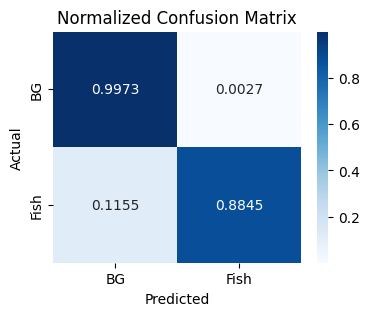

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.6448384523391724
      avg_dice_background            0.30014193058013916
  avg_dice_class_of_interest         0.30014193058013916
       avg_f1_background             0.9981896877288818
   avg_f1_class_of_interest          0.3304107189178467
      avg_iou_background             0.22808200120925903
   avg_iou_class_of_interest         0.22808200120925903
   avg_precision_background          0.9999447464942932
avg_precision_class_of_interest      0.25407886505126953
     avg_recall_background           0.9964649677276611
 avg_recall_class_of_interest        0.6033022403717041
────────────────────────────────────────────────────────────────────────────────────

In [193]:
torch.set_float32_matmul_precision('medium')

tester = pl.Trainer(
    precision='16-mixed',
    accelerator='gpu',
)

results = tester.test(trained_model, test_loader)

# INFERENCE AND SAVING PREDICTIONS

In [198]:
torch.set_float32_matmul_precision('medium')

trained_model.predict(test_loader, output_dir = output_predictions, file_prefix = date)

  0%|          | 0/16 [00:00<?, ?it/s]

# STICH PREDICTIONS TOGETHER, CREATE ONE MASK

In [5]:
import re
from skimage.transform import resize

date = '0707'
zarr_dir = '/media/ubuntu/E/processed/070707'
zarr_paths = [os.path.join(zarr_dir, z, z + '_Sv.zarr') for z in os.listdir(zarr_dir)]
combined_dataset = load_combine_process_zarrs(zarr_paths, ignore_vars = [])
depth = combined_dataset.dims['depth']
width = combined_dataset.dims['ping_time']

# It's important that prediction files are sorted properly
prediction_files = [f for f in os.listdir(output_predictions) if f.startswith(date)]
prediction_files = [date+'_'+str(i)+'.npy' for i in range(0, len(prediction_files))]

threshold = 0.5  # Threshold for converting logits to binary mask

# Function to convert logits to binary mask and resize to original size
def process_and_resize(file, depth_size):
    # Load the predictions
    predictions = np.load(file)
    
    # Determine the batch size dynamically
    batch_size = predictions.shape[0]
    
    # Convert to binary mask
    preds = torch.sigmoid(torch.from_numpy(predictions)) > threshold
    masks = preds.numpy().astype(int)
    
    # Initialize an empty array to hold the resized masks for the current batch
    resized_batch = np.zeros((depth_size, depth_size * batch_size))
    
    for i in range(batch_size):
        mask = masks[i, 0]  # Assuming masks are of shape (BATCHSIZE, 1, 512, 512)
        resized_mask = resize(mask, (depth_size, depth_size), preserve_range=True, anti_aliasing=True).astype(int)
        resized_batch[:, i*depth_size:(i+1)*depth_size] = resized_mask
    
    return resized_batch

def stich_masks_together(prediction_files):
    combined_mask = np.zeros((depth, width))
    current_col = 0
    for i, file in tqdm(enumerate(prediction_files), total = len(prediction_files)):
        file_path = os.path.join(output_predictions, file)
        binary_mask = process_and_resize(file_path, depth)
        mask_width = binary_mask.shape[1]
        if i == len(prediction_files) - 1:
            last_chunk_size = width - current_col
            if last_chunk_size < mask_width:
                binary_mask = binary_mask[:, :last_chunk_size]
                mask_width = last_chunk_size
        combined_mask[:, current_col:current_col+mask_width] = binary_mask
        current_col += mask_width
    return combined_mask

combined_mask = stich_masks_together(prediction_files)

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/tmp/ipykernel_1542095/3315316465.py:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  depth = combined_dataset.dims['depth']
/tmp/ipykernel_1542095/3315316465.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  width = combined_dataset.dims['ping_time']


  0%|          | 0/16 [00:00<?, ?it/s]

# OUTPUT IN DIFFERENT FORMATS

In [6]:
# binary mask as numpy array
np.save(os.path.join(output_predictions_combined, date + '.npy'), combined_mask)

# add to xarray and save as zarr
def save_as_xarray(out_file, combined_mask, combined_dataset):
    combined_dataset['mask'] = (('depth', 'ping_time'), combined_mask)
    combined_dataset = combined_dataset.chunk({'depth': 256, 'ping_time': 1000})
    combined_dataset.to_zarr(out_file, mode='w', safe_chunks=False)
save_as_xarray(os.path.join(output_predictions_combined, date + '.zarr'), combined_mask, combined_dataset)

## Save as .EVR

In [8]:
from scipy import ndimage
from skimage.measure import find_contours
from multiprocessing import Pool, cpu_count

def process_region(args):
    region_id, labeled_mask, ping_times, depths = args
    region_mask = (labeled_mask == region_id)
    contours = find_contours(region_mask, 0.5) # very slow functions
    
    if not contours:
        return None

    # Assuming the largest contour is the region boundary
    contour = max(contours, key=len)
    point_count = len(contour)
    
    # Region structure
    region_structure = []
    region_structure.append("13")
    region_structure.append(f"{point_count}")
    region_structure.append(f"{region_id}")
    region_structure.append("0")  # Selected
    region_structure.append("7")  # Region creation type (assuming "Detect Schools command")
    region_structure.append("-1")  # Dummy
    region_structure.append("1")  # Bounding rectangle calculated
    
    # Calculate bounding rectangle (x1, y1, x2, y2)
    depth_coords, ping_coords = np.where(region_mask)
    ping_left = ping_coords.min()
    ping_right = ping_coords.max()
    depth_top = depth_coords.min()
    depth_bottom = depth_coords.max()
    
    # Extract corresponding ping_time and depth
    left_time = datetime.utcfromtimestamp(ping_times[int(ping_left)].astype('datetime64[s]').astype(int))
    right_time = datetime.utcfromtimestamp(ping_times[int(ping_right)].astype('datetime64[s]').astype(int))
    left_time_str = left_time.strftime("%Y%m%d %H%M%S%f")
    right_time_str = right_time.strftime("%Y%m%d %H%M%S%f")

    depth_top = depths[int(depth_top)]
    depth_bottom = depths[int(depth_bottom)]

    region_structure.append(f"{left_time_str} {depth_top}")
    region_structure.append(f"{right_time_str} {depth_bottom}")
    
    region_content = []
    region_content.append(" ".join(region_structure))
    
    region_content.append("1")  # Number of lines of notes
    region_content.append("ML inference")  # Region notes
    region_content.append("0")  # Number of lines of detection settings
    region_content.append("Fish")  # Example classification
    
    # Points data
    points_str = []
    for point in contour:
        y, x = point
        point_time = datetime.utcfromtimestamp(ping_times[int(x)].astype('datetime64[s]').astype(int))
        point_time_str = point_time.strftime("%Y%m%d %H%M%S%f")
        depth_value = depths[int(y)]
        points_str.append(f"{point_time_str} {depth_value:.10f}")

    points_str.append("1")  # Region type (analysis)
    region_content.append(" ".join(points_str))
    
    # Region type and name
    region_content.append(f"Region{region_id}")

    return "\r\n".join(region_content)

def save_as_evr(mask, ping_times, depths, output_file, echoview_version="11.1.49.40912"):
    # Identify regions in the mask
    labeled_mask, num_features = ndimage.label(mask)
    
    # Initialize EVR content with header
    evr_header = []
    evr_header.append(f"EVRG 7 {echoview_version}")
    evr_header.append(f"{num_features}")
    #evr_header.append("3")
    
    # Prepare arguments for parallel processing
    args = [(region_id, labeled_mask, ping_times, depths) for region_id in range(1, num_features+1)]
    
    with Pool(cpu_count()) as pool:
        region_contents = list(tqdm(pool.imap(process_region, args), total=num_features))

    # Write to file in batch
    with open(output_file, 'w') as file:
        file.write("\r\n".join(evr_header))
        for region_content in region_contents:
            if region_content is not None:
                file.write("\r\n\n" + region_content)

ping_times = np.sort(combined_dataset['ping_time'].values)
depths = np.sort(combined_dataset['depth'].values)

output_file = os.path.join(output_predictions_combined, date + '.evr')
save_as_evr(combined_mask, ping_times, depths, output_file)

  0%|          | 0/838 [00:00<?, ?it/s]

# PLOT PREDICTION MASK AND ORIGINAL MASK

In [7]:
date = '0707'
zarr_dir = '/media/ubuntu/E/processed/070707'
zarr_paths = [os.path.join(zarr_dir, z, z + '_Sv.zarr') for z in os.listdir(zarr_dir)]
combined_dataset = load_combine_process_zarrs(zarr_paths, ignore_vars = ignore_vars)
combined_mask = np.load('/media/ubuntu/E/Test_ML/combined_predictions/0707.npy')

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


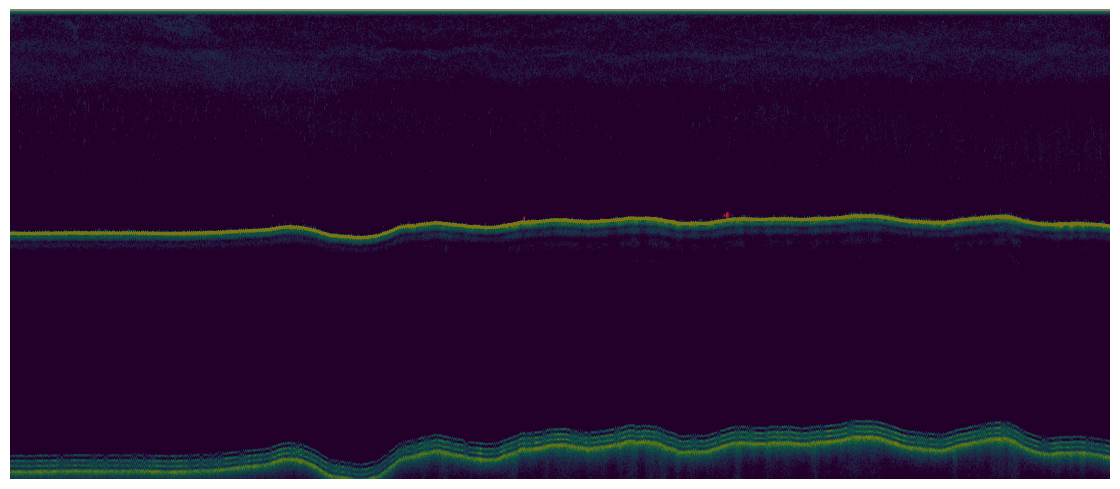

In [24]:
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Define the range for slicing
#start_index = 4700
#end_index = 4800
start_value = datetime.strptime("2007-07-07 04:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
end_value = datetime.strptime("2007-07-07 05:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
start_value = np.datetime64(start_value)
end_value = np.datetime64(end_value)
start_index = np.searchsorted(combined_dataset['ping_time'].values, start_value)
end_index = np.searchsorted(combined_dataset['ping_time'].values, end_value)

# Extract the section from Sv data and convert to numpy array
img = combined_dataset.Sv.isel(channel=1, ping_time=slice(start_index, end_index)).T.values

# Apply binary dilation to make the mask more visible
dilated_mask = binary_dilation(combined_mask[:, start_index:end_index], structure=np.ones((5, 5)))

# Create a red mask for overlay
red_mask = np.zeros((*dilated_mask.shape, 3))  # Shape (height, width, 3) for RGB
red_mask[..., 0] = dilated_mask  # Red channel
red_mask[..., 1] = 0             # Green channel
red_mask[..., 2] = 0             # Blue channel

# Create a figure
fig, ax = plt.subplots(figsize=(11, 4.7))

# Overlay the red mask on the image
ax.imshow(img, aspect='auto', cmap='viridis', vmin=-70, vmax=-30)
ax.imshow(red_mask, alpha=0.5, aspect='auto')  # Overlay with transparency
ax.axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust subplots to avoid tight_layout
plt.show()

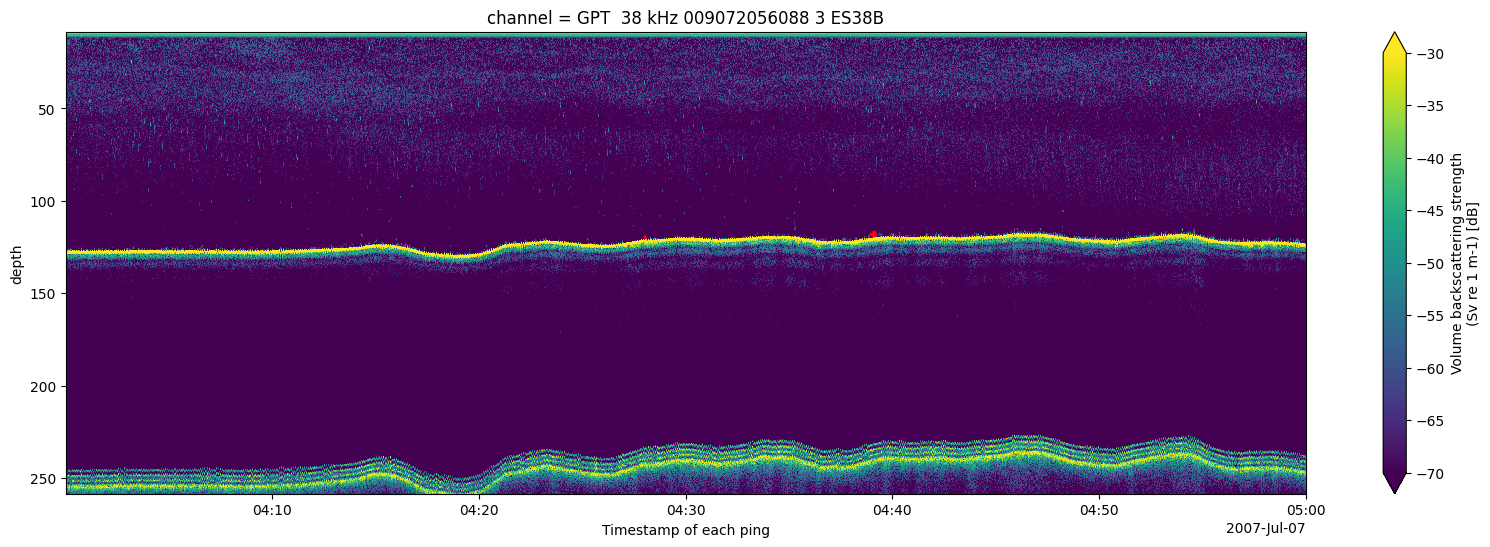

In [35]:
#evr_file = '/media/ubuntu/E/EVR_region_files/07July.EVR'
#region_classes=["Def herring", "Prob herring", "Poss herring", "Surface herring", "Mackerel", 
#                                                   "Gadoids", "Norway pout", "unidentified fish"]
evr_file = '/media/ubuntu/E/Test_ML/combined_predictions/0707.evr'
region_classes = 'Fish'

regions2d = er.read_evr(evr_file)
regions_def = regions2d.select_region(region_class=region_classes)

# Plotting the echogram data and the school region
plt.figure(figsize=(20, 6))
for _, point in regions_def.iterrows():
    plt.plot(point["time"], point["depth"], fillstyle='full', markersize=50, color="red")

combined_dataset.Sv.isel(channel=1, ping_time=slice(start_index, end_index)).T.plot(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap="viridis")

In [57]:
evr_file = '/media/ubuntu/E/Test_ML/combined_predictions/0707.evr'
regions2d = er.read_evr(evr_file)
predicted_def = regions2d.select_region(region_class=['Fish'])

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
0,0707.evr,EVRG,7,11.1.49.40912,1,13,49,0,7,-1,...,2007-07-07 14:18:22,25.506823,29.157159,Fish,1,Region1,"[2007-07-07T14:18:22.000000000, 2007-07-07T14:...","[29.1571592762, 29.1571592762, 29.1571592762, ...",[ML inference],[]
1,0707.evr,EVRG,7,11.1.49.40912,2,13,73,0,7,-1,...,2007-07-07 13:40:34,25.891069,32.039004,Fish,1,Region2,"[2007-07-07T13:40:34.000000000, 2007-07-07T13:...","[32.0390040346, 32.0390040346, 32.0390040346, ...",[ML inference],[]
2,0707.evr,EVRG,7,11.1.49.40912,3,13,99,0,7,-1,...,2007-07-07 14:18:22,32.231127,40.876661,Fish,1,Region3,"[2007-07-07T14:18:22.000000000, 2007-07-07T14:...","[40.8766612935, 40.8766612935, 40.8766612935, ...",[ML inference],[]


In [53]:
predicted_def['region_bbox_left'] = predicted_def['region_bbox_left'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S.%f') if not pd.isnull(x) else None)
predicted_def.region_bbox_left.iloc[0]

'2007-07-07 14:18:16.000000'

In [29]:
predicted_def[(predicted_def.region_bbox_left > datetime.strptime("2007-07-07 02:08:00.000", "%Y-%m-%d %H:%M:%S.%f")) & 
                (predicted_def.region_bbox_right < datetime.strptime("2007-07-07 02:10:00.000", "%Y-%m-%d %H:%M:%S.%f"))]

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
359,0707.evr,EVRG,7,11.1.49.40912,360,13,153,0,7,-1,...,2007-07-07 02:09:20,112.923,115.997,Fish,1,Region360,"[2007-07-07T02:09:20.000000000, 2007-07-07T02:...","[115.9967479945, 115.9967479945, 115.996747994...",[ML inference],[]


In [54]:
predicted_def.iloc[0]

file_name                                                             0707.evr
file_type                                                                 EVRG
evr_file_format_number                                                       7
echoview_version                                                 11.1.49.40912
region_id                                                                    1
region_structure_version                                                    13
region_point_count                                                          49
region_selected                                                              0
region_creation_type                                                         7
dummy                                                                       -1
region_bbox_calculated                                                       1
region_bbox_left                                    2007-07-07 14:18:16.000000
region_bbox_right                                   